## LOAD DATASETS

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

## TUNA AND FEATURE ENGINEERING

In [5]:
def apply_tuna(df):
    """
    TUNA-inspired method with softer penalties to preserve detail
    Core TUNA principles with less aggressive corrections
    """
    df_result = df.copy()
    df_original = df.copy()
    
    cpu_columns = [col for col in df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    # Statistics tracking
    feature_outlier_stats = {}
    noise_stats = {}
    total_outliers_detected = 0
    successful_models = 0
    total_noise_reduction = 0.0
    ml_corrections_applied = 0
    total_stable_points = 0
    
    for cpu_col in cpu_columns:
        print(f"  🔍 Processing {cpu_col}...")
        
        # PHASE 1: Outlier Detection using Relative Range (TUNA method)
        outlier_mask = pd.Series(False, index=df_result.index)
        outliers_detected = 0
        
        if 'Time' in df_result.index.names:
            grouped = df_result.groupby(pd.Grouper(freq='2min'))
            
            for name, group in grouped:
                if len(group) < 2:
                    continue
                
                values = group[cpu_col].values
                if len(values) > 1 and np.mean(values) > 0:
                    # TUNA formula: relative range
                    relative_range = (np.max(values) - np.min(values)) / np.mean(values)
                    
                    if relative_range > 0.30:  # TUNA threshold
                        outlier_mask.loc[group.index] = True
                        outliers_detected += 1
        
        # Calculate penalty based on outlier characteristics (softer than TUNA's 0.50)
        if outlier_mask.sum() > 0:
            stable_mask = ~outlier_mask
            stable_data = df_original[stable_mask][cpu_col]
            unstable_data = df_original[outlier_mask][cpu_col]
            
            if len(stable_data) > 0 and len(unstable_data) > 0:
                stable_mean = stable_data.mean()
                unstable_mean = unstable_data.mean()
                
                # Softer penalties to preserve detail
                if unstable_mean > stable_mean * 1.2:  # High spikes
                    penalty_factor = 0.80  # Less aggressive than 0.50
                    penalty_direction = "DOWN"
                elif unstable_mean < stable_mean * 0.8:  # Low spikes
                    penalty_factor = 1.20  # Gentle boost
                    penalty_direction = "UP"
                else:  # Near baseline
                    penalty_factor = 0.90  # Very gentle reduction
                    penalty_direction = "NEUTRAL"
            else:
                penalty_factor = 0.85
                penalty_direction = "DEFAULT"
        else:
            penalty_factor = 1.0
            penalty_direction = "NONE"
        
        feature_outlier_stats[cpu_col] = {
            'outliers_detected': outliers_detected,
            'outlier_time_points': outlier_mask.sum(),
            'relative_threshold': 0.30,
            'penalty_direction': penalty_direction,
            'penalty_factor': penalty_factor
        }
        
        total_outliers_detected += outliers_detected
        print(f"    ✅ {outliers_detected} unstable periods detected")
        
        # PHASE 2: Train Random Forest on STABLE data only (TUNA principle)
        try:
            # Feature engineering
            feature_df = df_original.copy()
            feature_df[f'{cpu_col}_lag1'] = feature_df[cpu_col].shift(1)
            feature_df[f'{cpu_col}_lag2'] = feature_df[cpu_col].shift(2)
            feature_df[f'{cpu_col}_rolling_mean_5'] = feature_df[cpu_col].rolling(5).mean()
            feature_df[f'{cpu_col}_rolling_std_5'] = feature_df[cpu_col].rolling(5).std()
            
            # Cross-CPU features
            other_cpus = [col for col in cpu_columns if col != cpu_col]
            if other_cpus:
                feature_df[f'{cpu_col}_vs_others_mean'] = feature_df[cpu_col] / (feature_df[other_cpus].mean(axis=1) + 0.001)
                feature_df[f'{cpu_col}_vs_others_max'] = feature_df[cpu_col] / (feature_df[other_cpus].max(axis=1) + 0.001)
            
            # Feature columns
            base_features = [col for col in feature_df.columns if col.startswith(f'{cpu_col}_')]
            other_cpu_features = [col for col in other_cpus[:3]]
            feature_columns = base_features + other_cpu_features
            feature_columns = [col for col in feature_columns if col in feature_df.columns]
            
            # Train only on stable periods (TUNA approach)
            stable_mask = ~outlier_mask
            stable_data = feature_df[stable_mask]
            
            if len(stable_data) > 15:
                target_mean = stable_data[cpu_col].mean()
                
                if target_mean > 0:
                    stable_data = stable_data.copy()
                    # TUNA target: relative error
                    stable_data['target'] = (stable_data[cpu_col] / target_mean) - 1
                    
                    clean_data = stable_data[feature_columns + ['target']].dropna()
                    
                    if len(clean_data) >= 10:
                        X = clean_data[feature_columns]
                        y = clean_data['target']
                        
                        scaler = StandardScaler()
                        X_scaled = scaler.fit_transform(X)
                        
                        model = RandomForestRegressor(
                            n_estimators=50,
                            max_depth=6,
                            min_samples_split=5,
                            random_state=42,
                            n_jobs=-1
                        )
                        model.fit(X_scaled, y)
                        
                        # PHASE 3: Apply corrections
                        corrections_this_cpu = 0
                        stable_points_this_cpu = 0
                        
                        for idx in df_result.index:
                            is_unstable = outlier_mask.loc[idx]
                            original_value = df_original.loc[idx, cpu_col]
                            
                            if is_unstable:
                                # Apply softer penalty to preserve detail
                                corrected_value = original_value * penalty_factor
                            else:
                                # Stable: Use Random Forest with gentler corrections
                                try:
                                    # Reconstruct features
                                    point_features = []
                                    
                                    for feat_col in feature_columns:
                                        if feat_col in feature_df.columns:
                                            point_features.append(feature_df.loc[idx, feat_col])
                                        else:
                                            point_features.append(0)
                                    
                                    # Predict and apply gentler correction
                                    features_scaled = scaler.transform([point_features])
                                    predicted_error = model.predict(features_scaled)[0]
                                    
                                    # Softer correction to preserve detail
                                    correction_factor = 1 / (1 + predicted_error * 0.5)  # Reduced from 1.0 to 0.5
                                    corrected_value = original_value * correction_factor
                                    corrections_this_cpu += 1
                                    
                                except:
                                    corrected_value = original_value
                                
                                stable_points_this_cpu += 1
                            
                            # Gentler bounds to preserve signal detail
                            corrected_value = max(corrected_value, original_value * 0.5)  # Less aggressive lower bound
                            corrected_value = min(corrected_value, original_value * 1.5)  # Less aggressive upper bound
                            corrected_value = max(corrected_value, 0.1)
                            
                            df_result.loc[idx, cpu_col] = corrected_value
                        
                        # Calculate noise reduction
                        original_stable_values = df_original[stable_mask][cpu_col]
                        cleaned_stable_values = df_result[stable_mask][cpu_col]
                        
                        original_std = original_stable_values.std()
                        cleaned_std = cleaned_stable_values.std()
                        noise_reduction = ((original_std - cleaned_std) / original_std) * 100 if original_std > 0 else 0
                        noise_reduction = max(0, min(noise_reduction, 50))
                        
                        noise_stats[cpu_col] = {
                            'noise_reduction_percent': noise_reduction,
                            'features_used': len(feature_columns),
                            'model_score': model.score(X_scaled, y),
                            'ml_corrections_applied': corrections_this_cpu,
                            'stable_points_total': stable_points_this_cpu
                        }
                        
                        successful_models += 1
                        total_noise_reduction += noise_reduction
                        ml_corrections_applied += corrections_this_cpu
                        total_stable_points += stable_points_this_cpu
                        
                        print(f"    ✅ {cpu_col}: {noise_reduction:.1f}% noise reduction, R² = {model.score(X_scaled, y):.3f}")
                        print(f"       📊 Penalty: {penalty_direction} ({penalty_factor}x)")
                        
                    else:
                        noise_stats[cpu_col] = {'status': 'insufficient_training_data'}
                else:
                    noise_stats[cpu_col] = {'status': 'zero_mean_target'}
            else:
                noise_stats[cpu_col] = {'status': 'insufficient_stable_data'}
                
        except Exception as e:
            noise_stats[cpu_col] = {'status': 'error', 'message': str(e)}
    
    # Add Total CPU
    df_result['Total_CPU_TUNA'] = df_result[cpu_columns].sum(axis=1)
    
    # Statistics
    avg_noise_reduction = total_noise_reduction / max(1, successful_models)
    overall_correction_rate = (ml_corrections_applied / total_stable_points * 100) if total_stable_points > 0 else 0
    
    outlier_stats = {
        'per_feature_outliers': feature_outlier_stats,
        'per_feature_noise': noise_stats,
        '_summary': {
            'total_features_processed': len(cpu_columns),
            'total_outliers': total_outliers_detected,
            'successful_noise_models': successful_models,
            'method': 'TUNA-Gentle',
            'relative_threshold': 0.30,
            'time_window': '2min',
            'outlier_penalty': 'adaptive',
            'ml_corrections_applied': ml_corrections_applied,
            'total_stable_points': total_stable_points,
            'correction_rate': overall_correction_rate,
            'noise_reduction': avg_noise_reduction
        }
    }
    
    return df_result, outlier_stats


def add_trend_features(df_tuna_cleaned):
    """
    Add essential trend features - simplified version
    """
    df_features = df_tuna_cleaned.copy()
    cpu_columns = [col for col in df_features.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9']]
    
    print("  🕒 Adding essential trend features...")
    
    # Only essential features to avoid overfitting
    for cpu_col in cpu_columns + ['Total_CPU_TUNA']:
        # Simple trend (3-period)
        df_features[f'{cpu_col}_trend_3'] = df_features[cpu_col].rolling(3).apply(
            lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 3 else np.nan
        )
        
        # Simple momentum (3-period)
        df_features[f'{cpu_col}_momentum_3'] = df_features[cpu_col] - df_features[cpu_col].shift(3)
        
        # Z-score normalization
        rolling_mean = df_features[cpu_col].rolling(5).mean()
        rolling_std = df_features[cpu_col].rolling(5).std()
        df_features[f'{cpu_col}_zscore'] = (df_features[cpu_col] - rolling_mean) / (rolling_std + 0.001)
    
    # Essential cross-relationships
    cpu_values = df_features[cpu_columns]
    df_features['CPU_load_balance'] = cpu_values.std(axis=1) / (cpu_values.mean(axis=1) + 0.001)
    df_features['CPU_max_min_ratio'] = cpu_values.max(axis=1) / (cpu_values.min(axis=1) + 0.001)
    
    added_features = len(df_features.columns) - len(df_tuna_cleaned.columns)
    print(f"    ✅ Added {added_features} essential features")
    
    return df_features

datasets_clean = {}
all_outlier_stats = {}

print(f"\n{'='*80}")
print("APPLYING TUNA TO ALL DATASETS")
print(f"{'='*80}")

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name}...")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Imposta il Time come index per il groupby
        df_indexed = df.set_index('Time')
        
        # Applica TUNA
        df_clean, stats = apply_tuna(df_indexed)
        
        # Resetta l'index
        df_clean = df_clean.reset_index()
        
        # Aggiungi trend features
        df_with_features = add_trend_features(df_clean)
        
        datasets_clean[dataset_name][source_type] = df_with_features
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']

        method = stats['_summary']['method']
        



APPLYING TUNA TO ALL DATASETS

📊 Processing IOWait...
  🔍 CPU STRESS:
  🔍 Processing cpu 0...
    ✅ 42 unstable periods detected
    ✅ cpu 0: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 1...
    ✅ 36 unstable periods detected
    ✅ cpu 1: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 2...
    ✅ 42 unstable periods detected
    ✅ cpu 2: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 3...
    ✅ 39 unstable periods detected
    ✅ cpu 3: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 4...
    ✅ 41 unstable periods detected
    ✅ cpu 4: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 5...
    ✅ 48 unstable periods detected
    ✅ cpu 5: 50.0% noise reduction, R² = 1.000
       📊 Penalty: DOWN (0.8x)
  🔍 Processing cpu 6...
    ✅ 37 unstable periods detected
    ✅ cpu 6: 50.0% noise reduction, R² = 1.000
       

## PLOTTING


COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA

🔄 Analyzing IOWait...

📊 Plotting Enhanced TUNA cleaned data for IOWait...


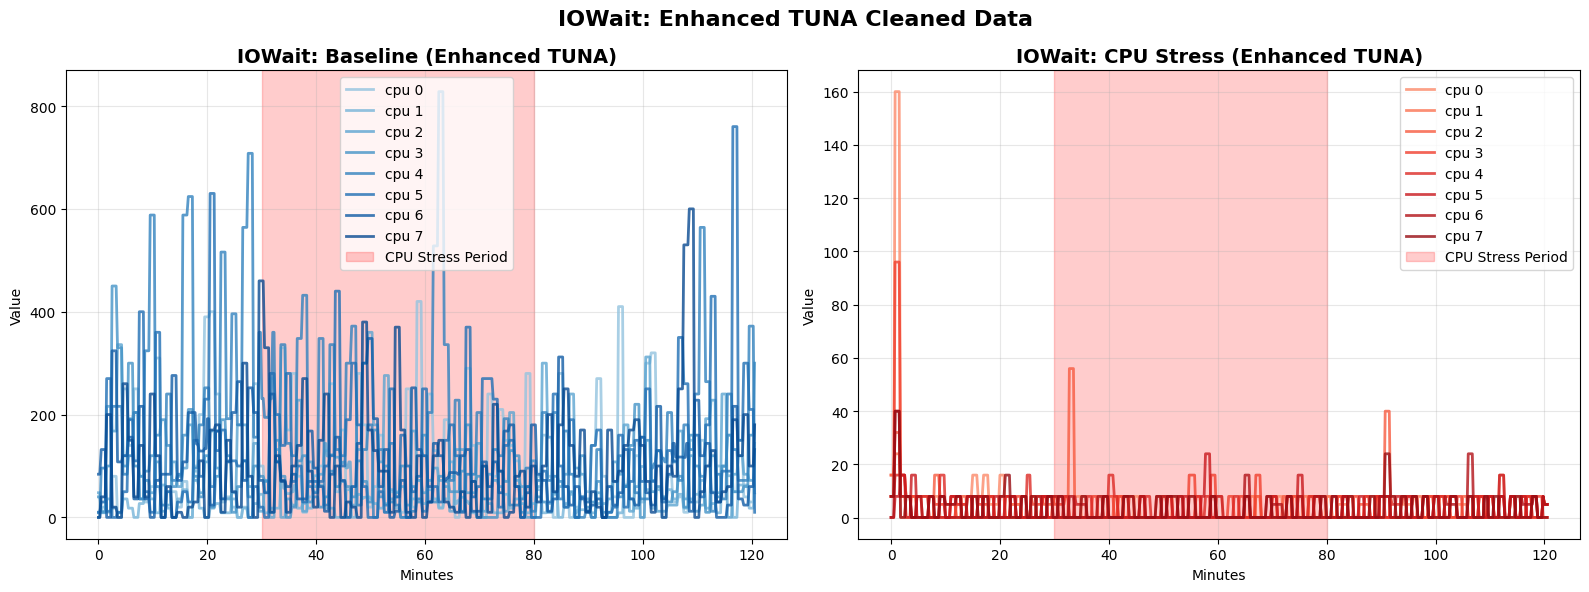

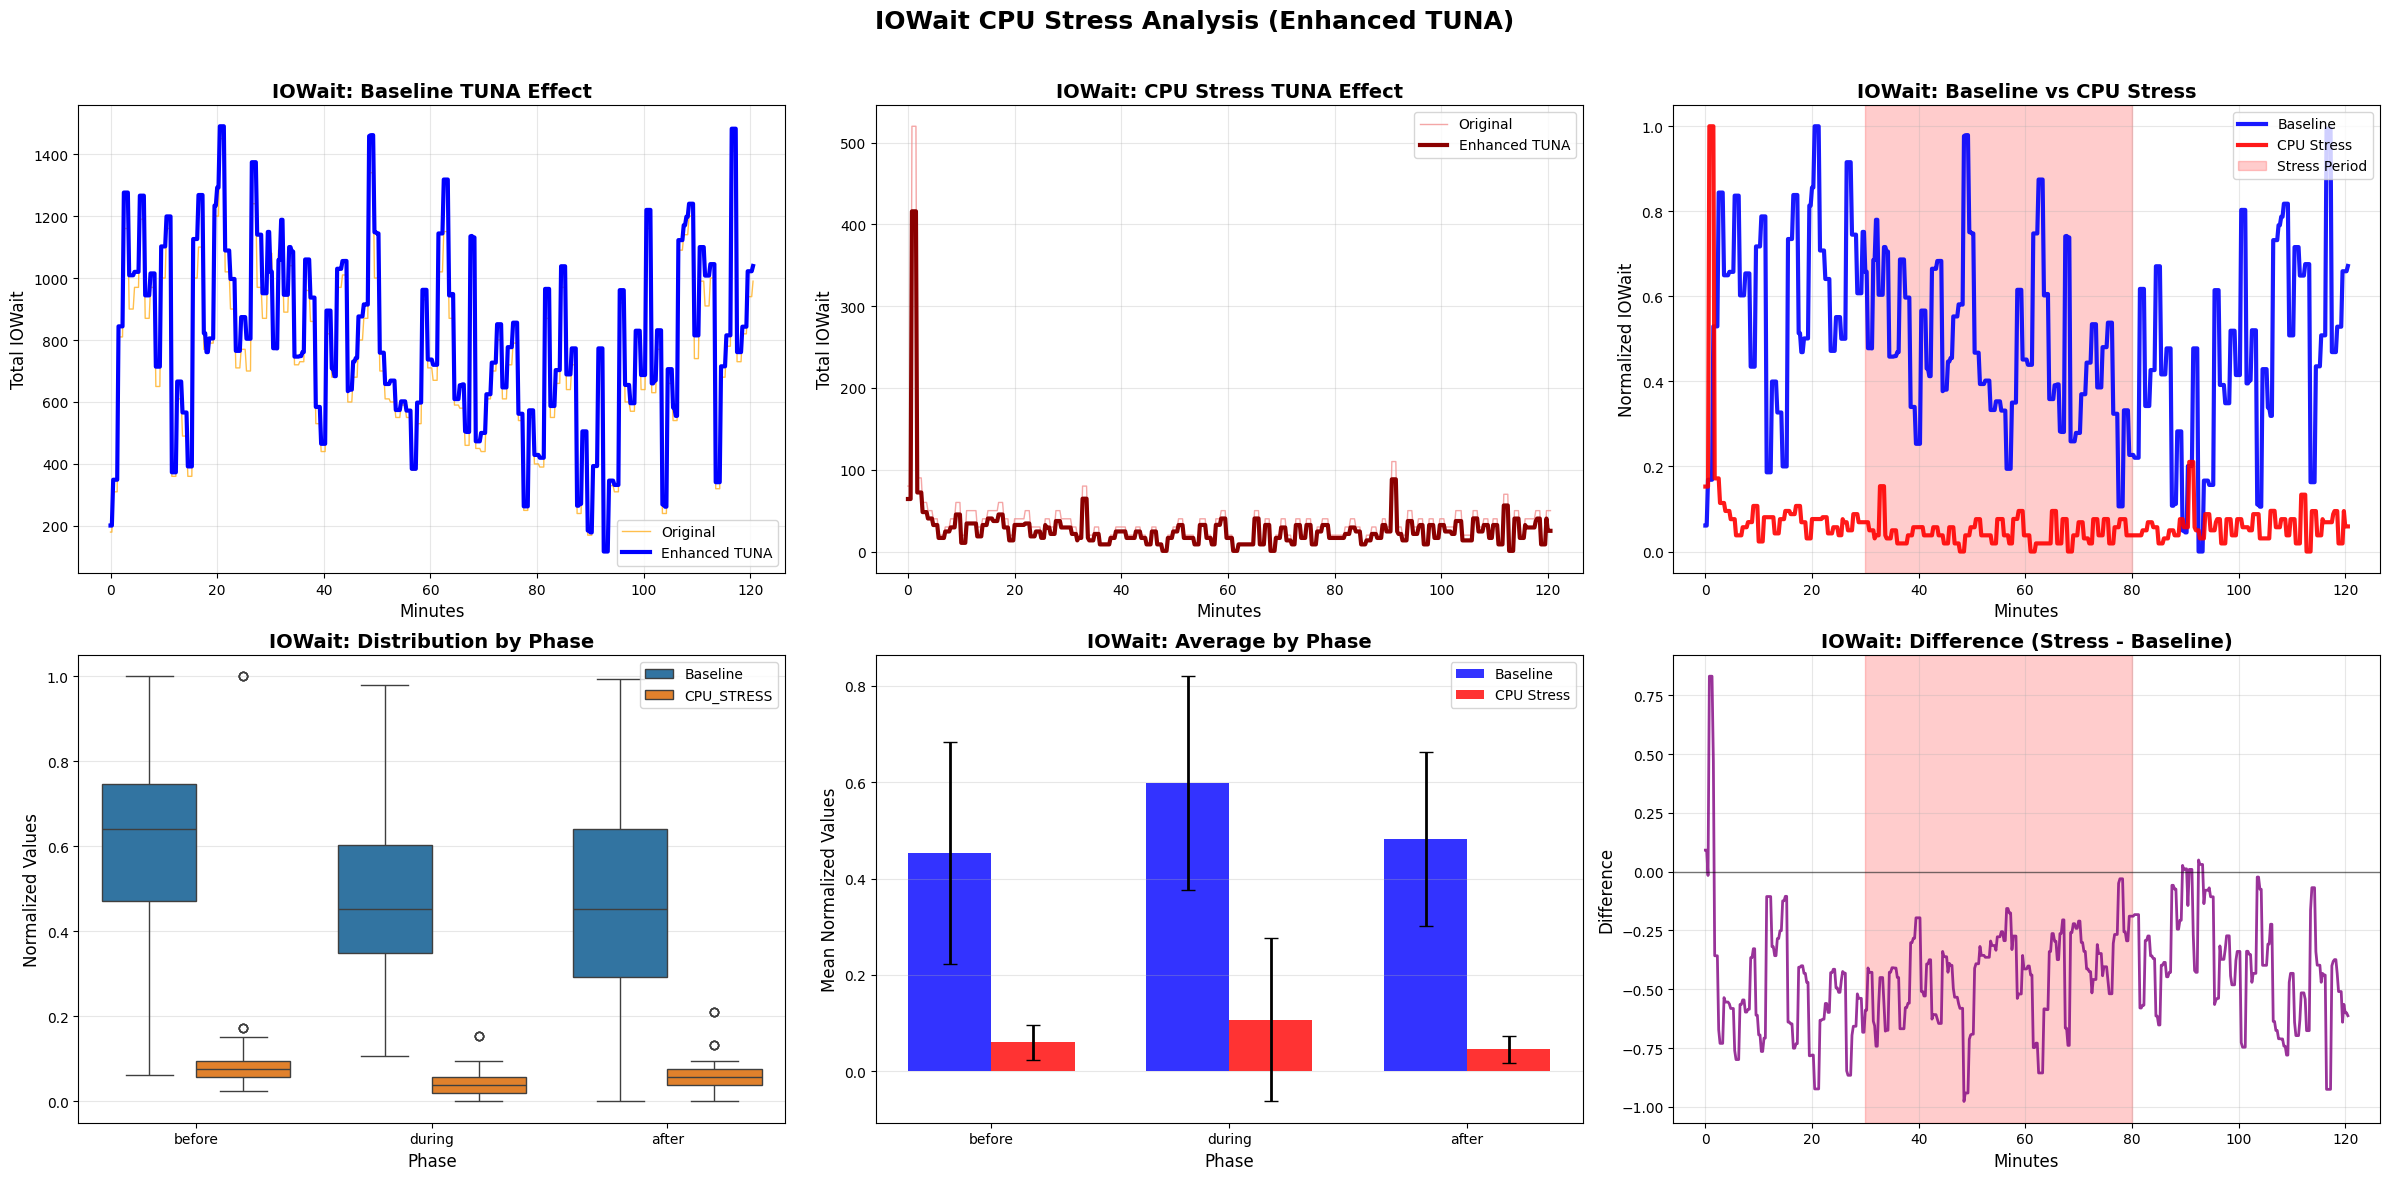

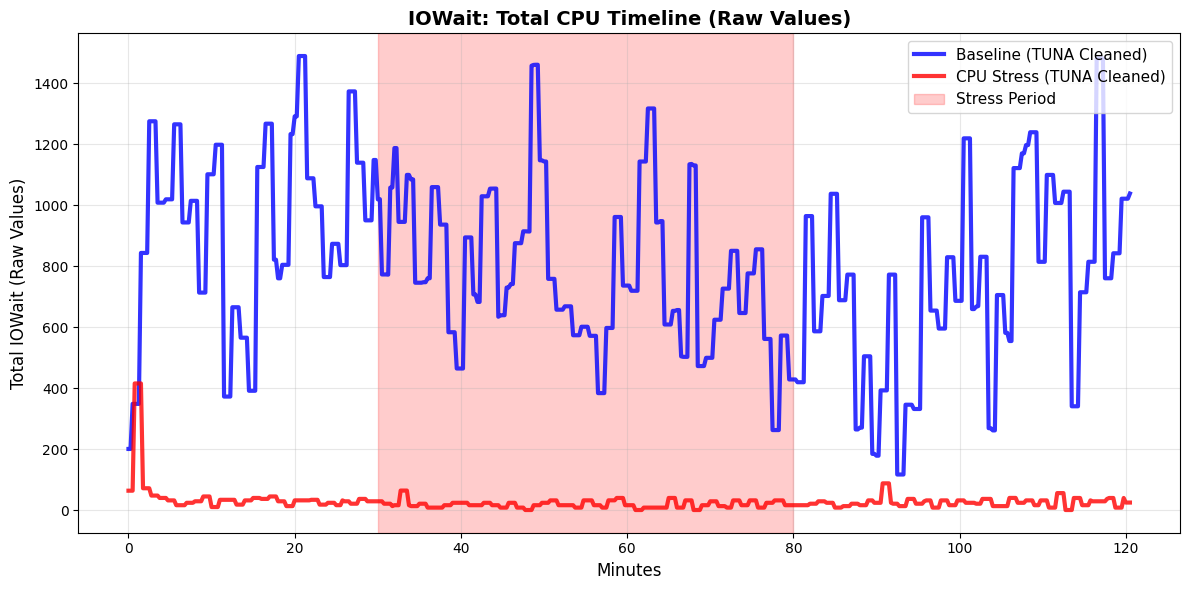


IOWAIT - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4531  0.2304  0.0000  0.9942
before  0.5981  0.2222  0.0610  1.0000
during  0.4823  0.1805  0.1062  0.9791

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0600  0.0361  0.0000  0.2107
before  0.1068  0.1695  0.0236  1.0000
during  0.0452  0.0287  0.0000  0.1537

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 19.25, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 33.90, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 21.46, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -82.15% (↘️ DECREASE)
  DURING  :  -90.63% (↘️ DECREASE)
  AFTER   :  -86.76% (↘️ DECREASE)

🔄 Analyzing IRQ...

📊 Plotting Enhanced TUNA cleaned data for IRQ...


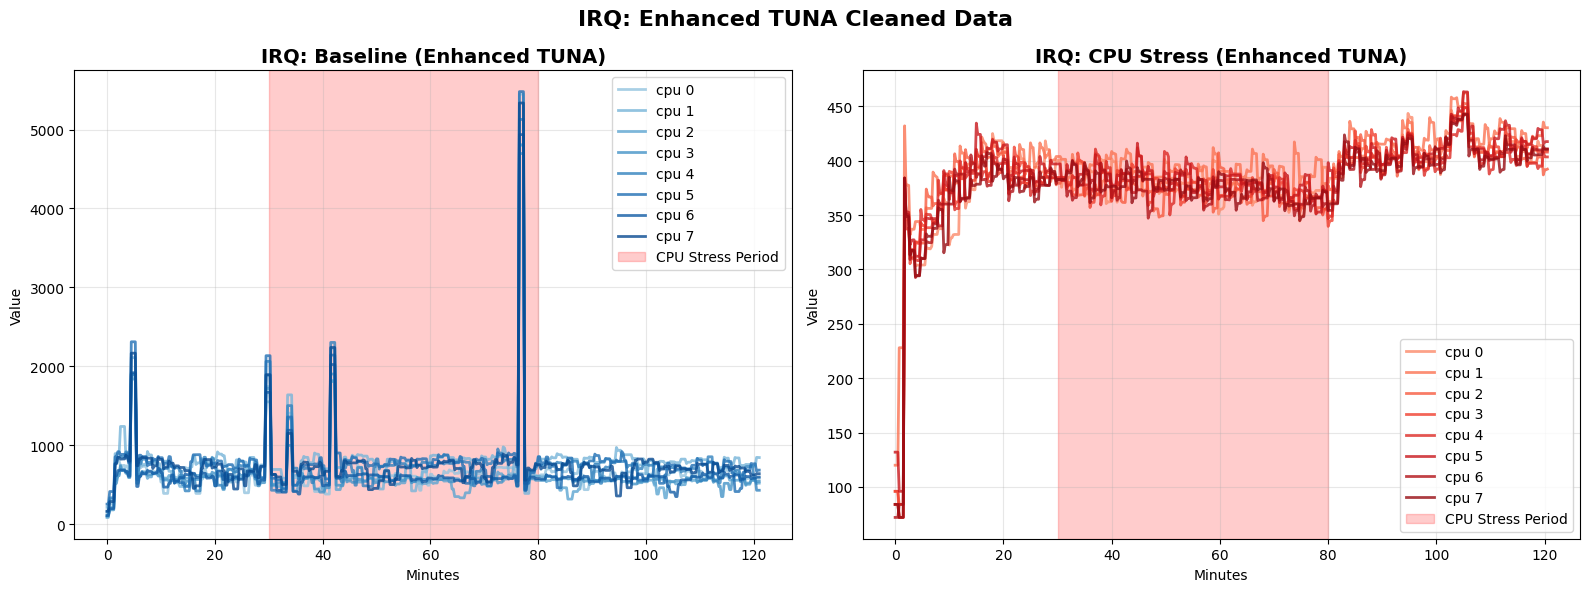

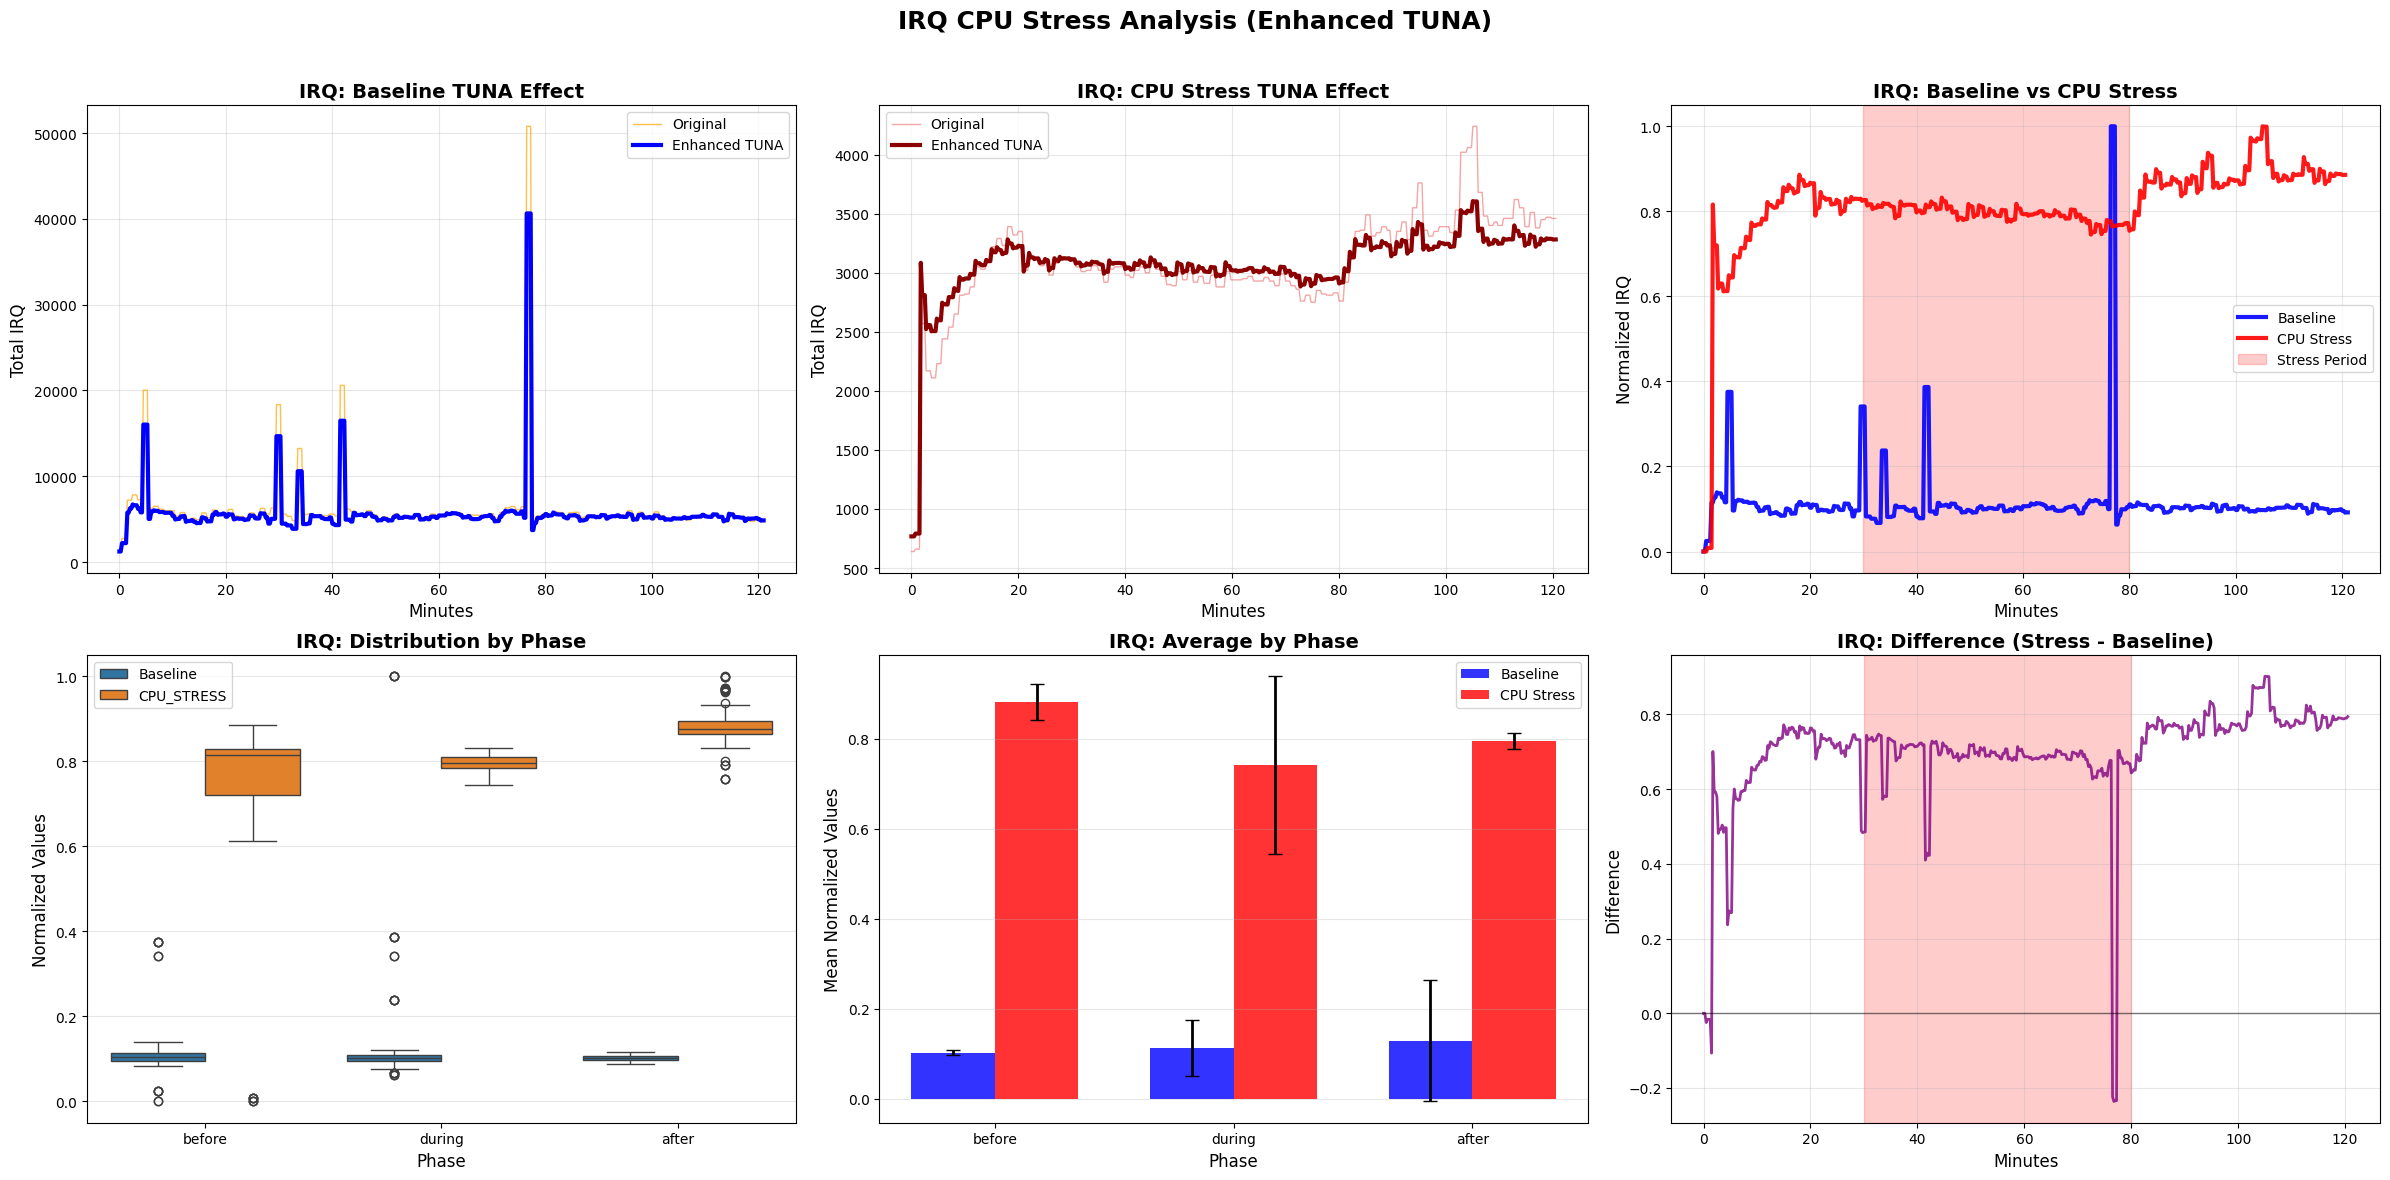

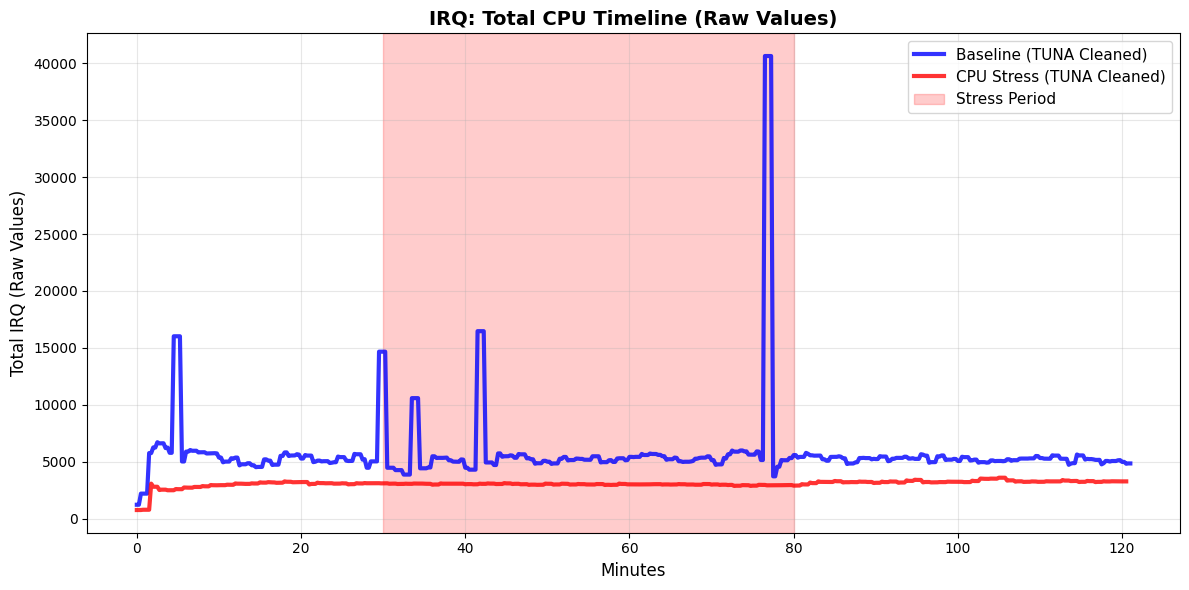


IRQ - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1019  0.0056  0.0890  0.1156
before  0.1135  0.0622  0.0000  0.3754
during  0.1283  0.1346  0.0634  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8821  0.0403  0.7576  1.0000
before  0.7422  0.1972  0.0000  0.8859
during  0.7949  0.0182  0.7453  0.8322

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-33.31, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-69.56, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-245.45, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  : +553.80% (↗️ INCREASE)
  DURING  : +519.54% (↗️ INCREASE)
  AFTER   : +765.33% (↗️ INCREASE)

🔄 Analyzing System...

📊 Plotting Enhanced TUNA cleaned data for System...


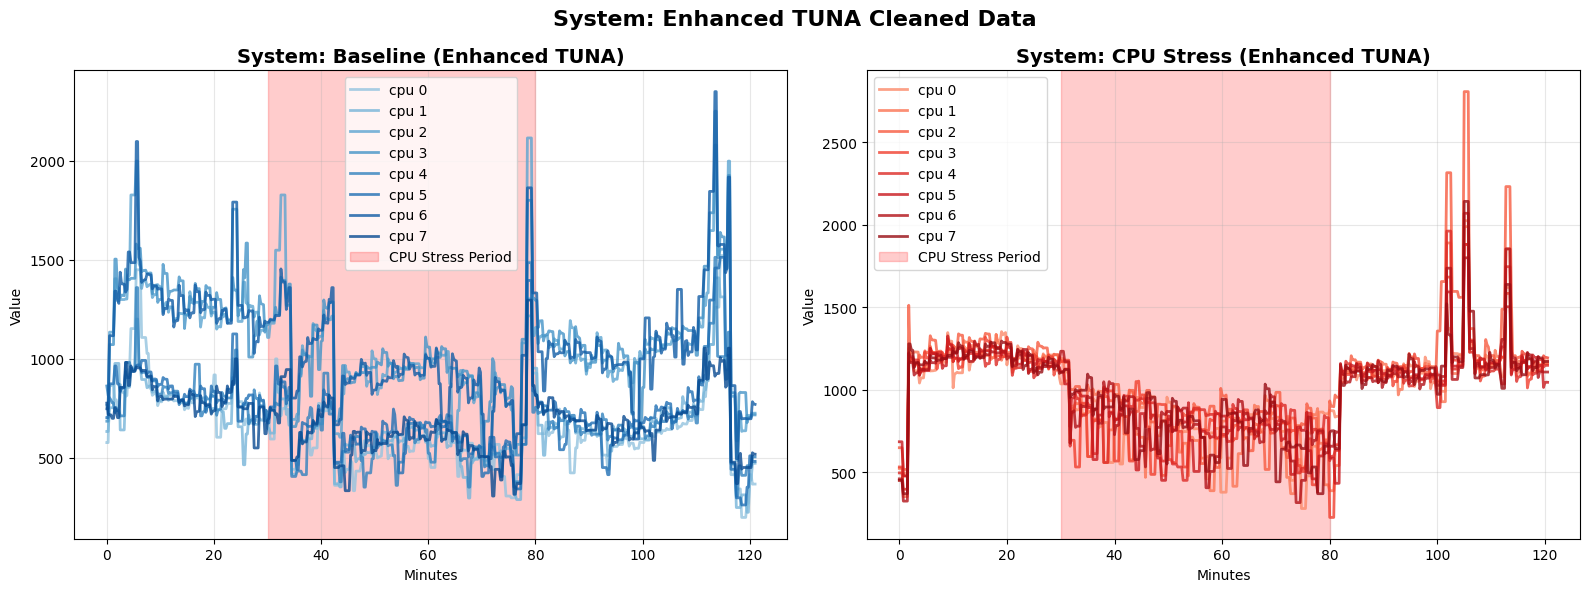

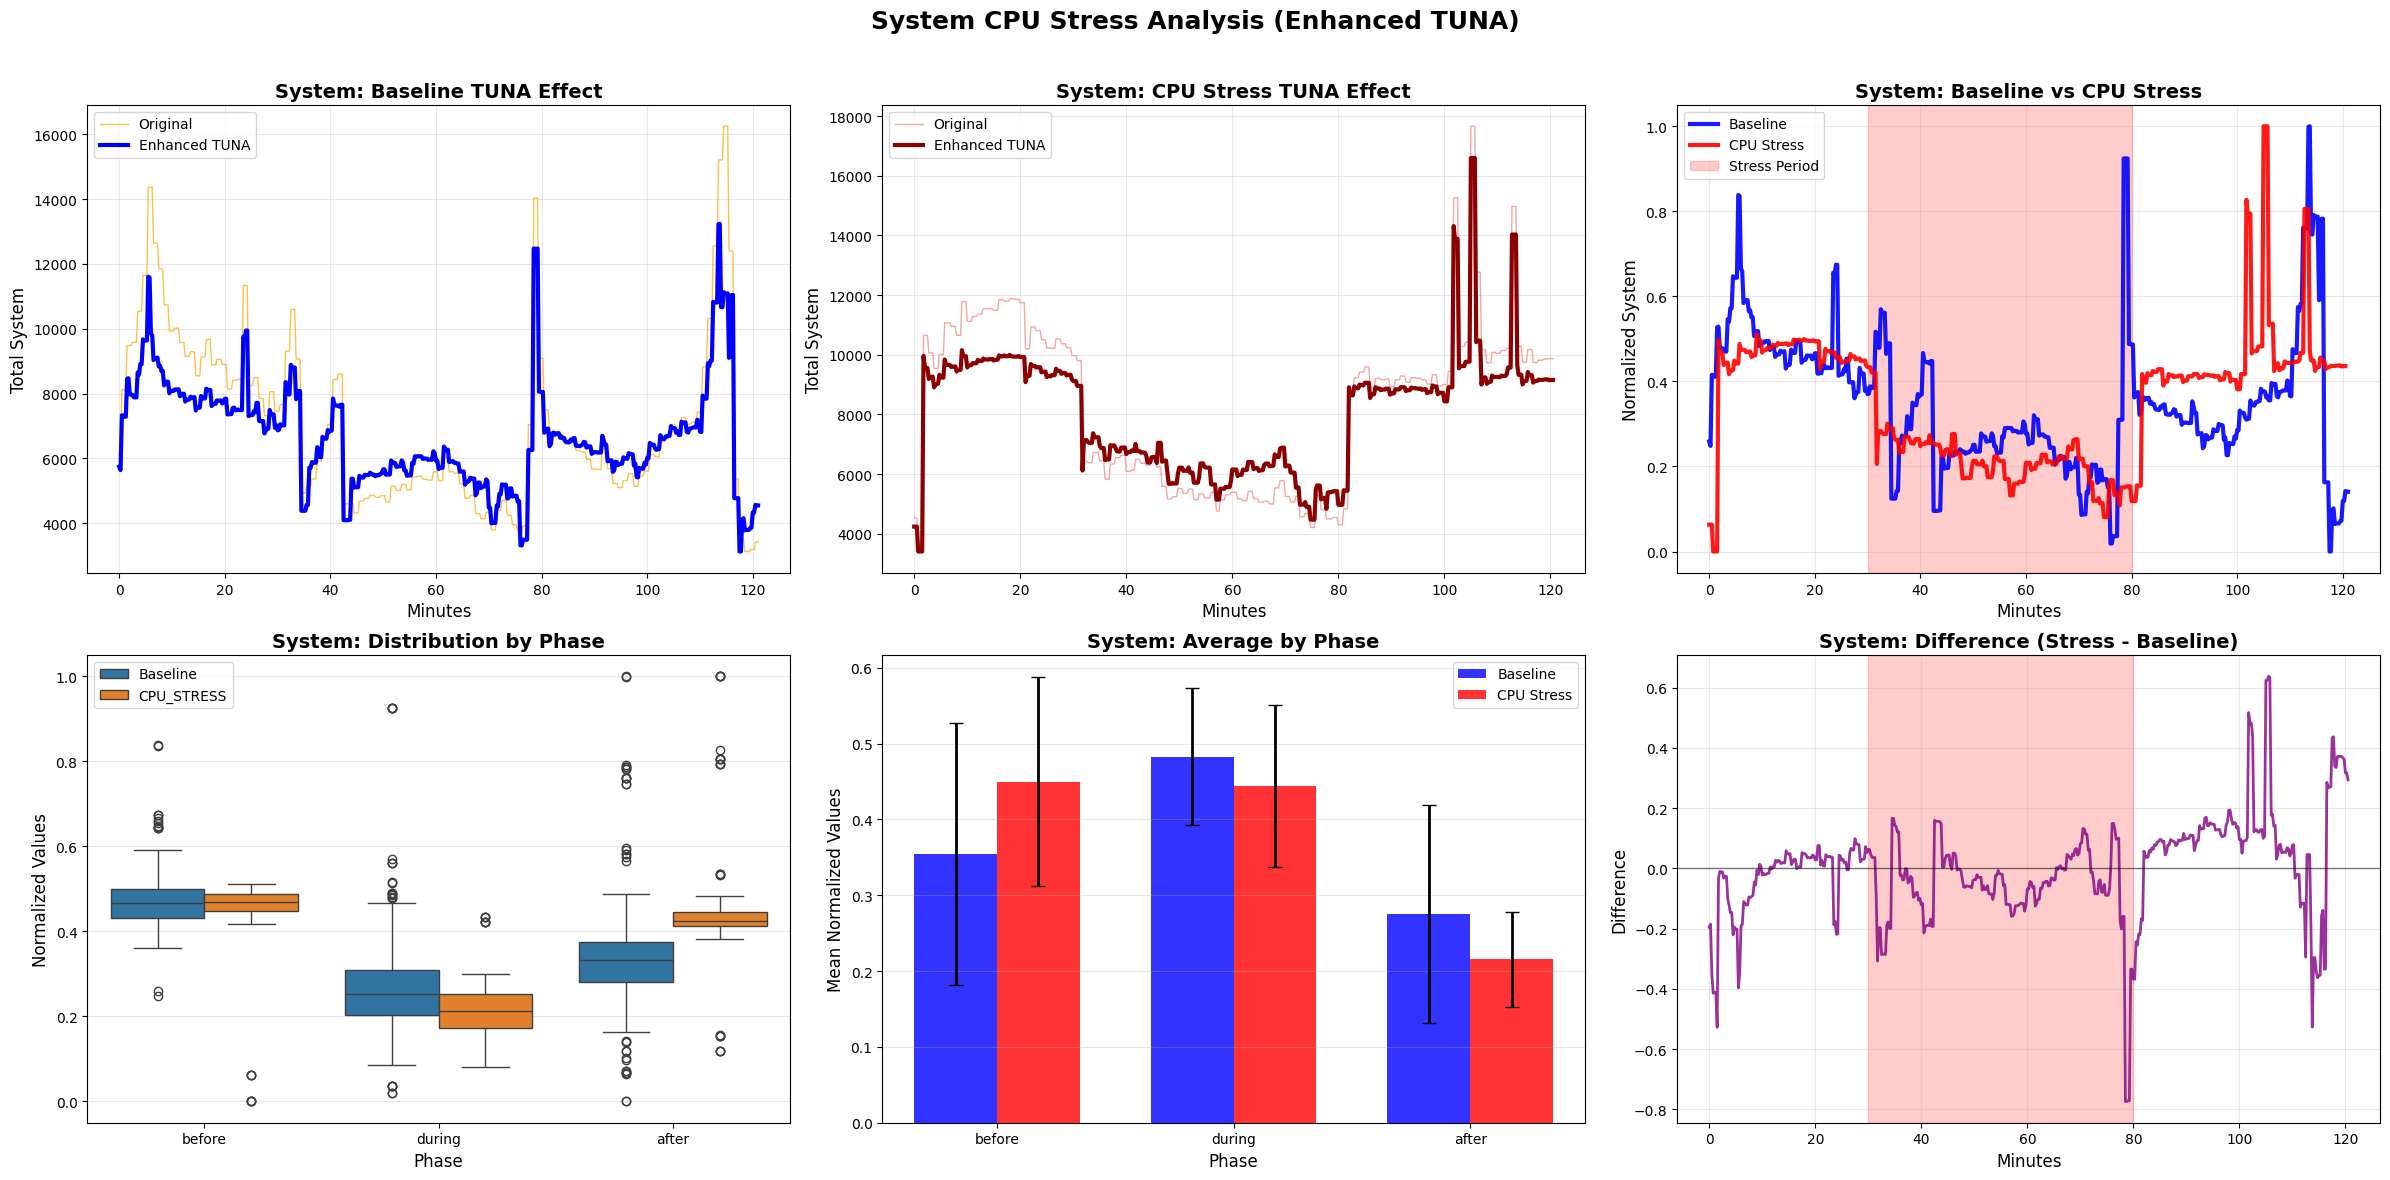

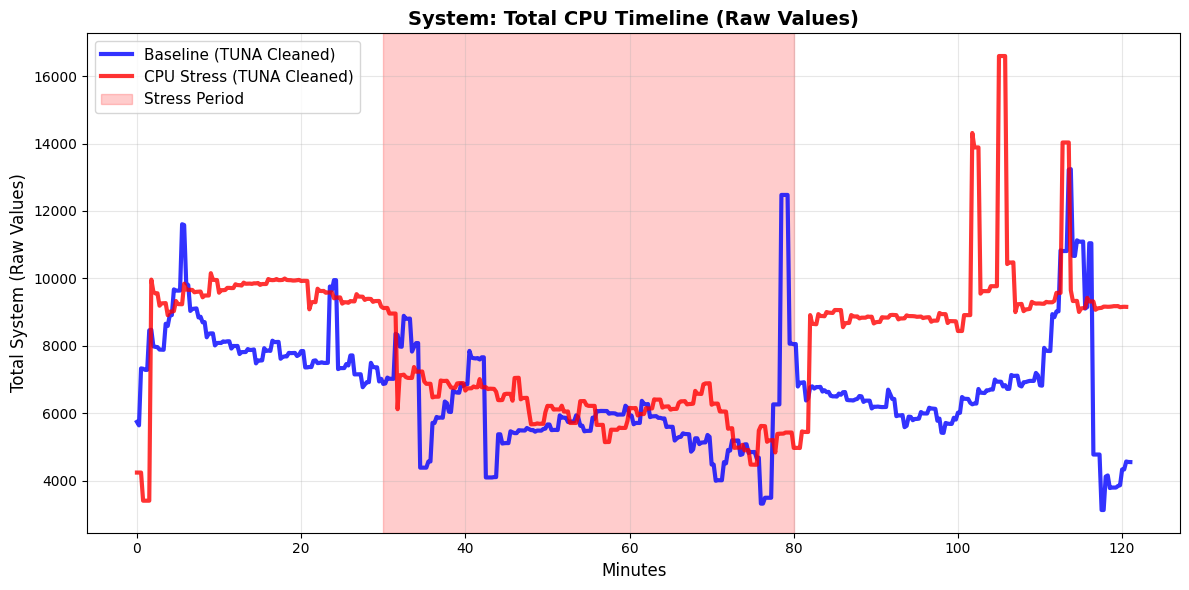


SYSTEM - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3544  0.1729  0.0000  1.0000
before  0.4826  0.0905  0.2484  0.8384
during  0.2746  0.1437  0.0188  0.9243

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4495  0.1379  0.1185  1.0000
before  0.4444  0.1066  0.0000  0.5116
during  0.2157  0.0627  0.0809  0.4334

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  2.99, p=  0.0031 (✅ SIGNIFICANT)
  DURING  : t=  5.33, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -5.49, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :   -7.92% (↘️ DECREASE)
  DURING  :  -21.44% (↘️ DECREASE)
  AFTER   :  +26.85% (↗️ INCREASE)

🔄 Analyzing User...

📊 Plotting Enhanced TUNA cleaned data for User...


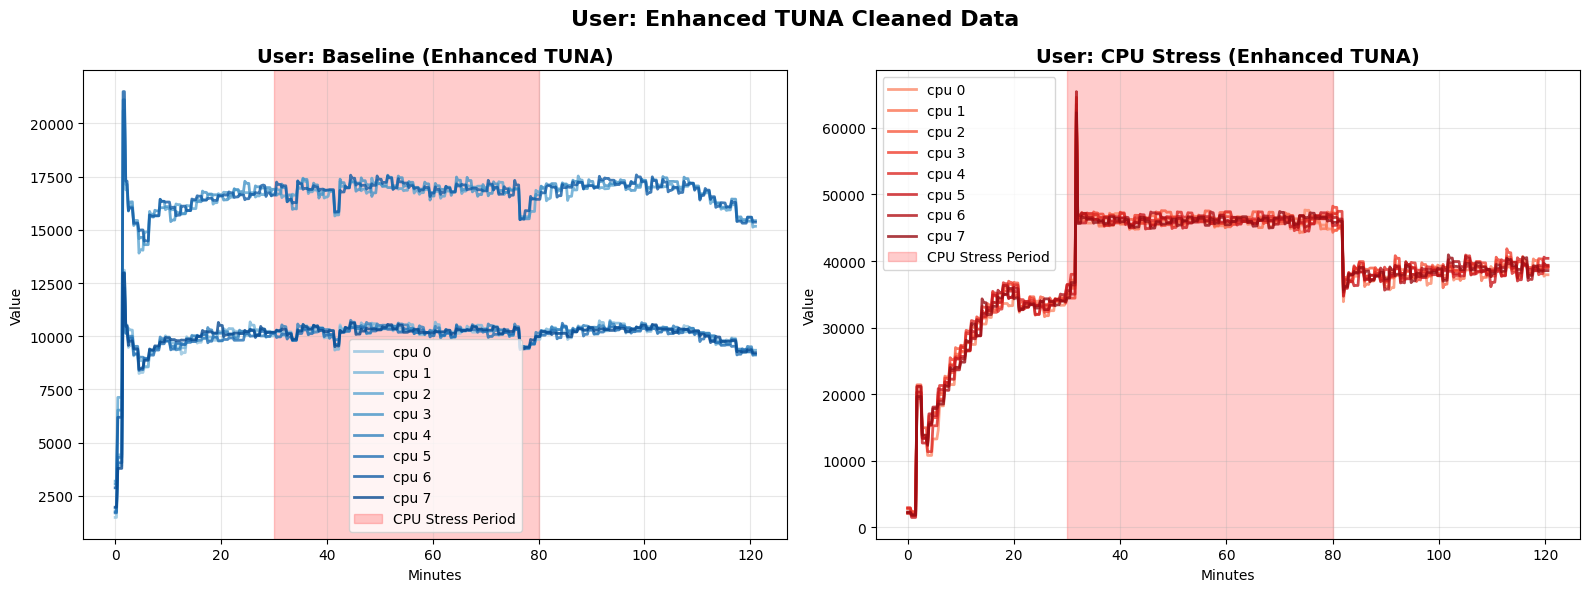

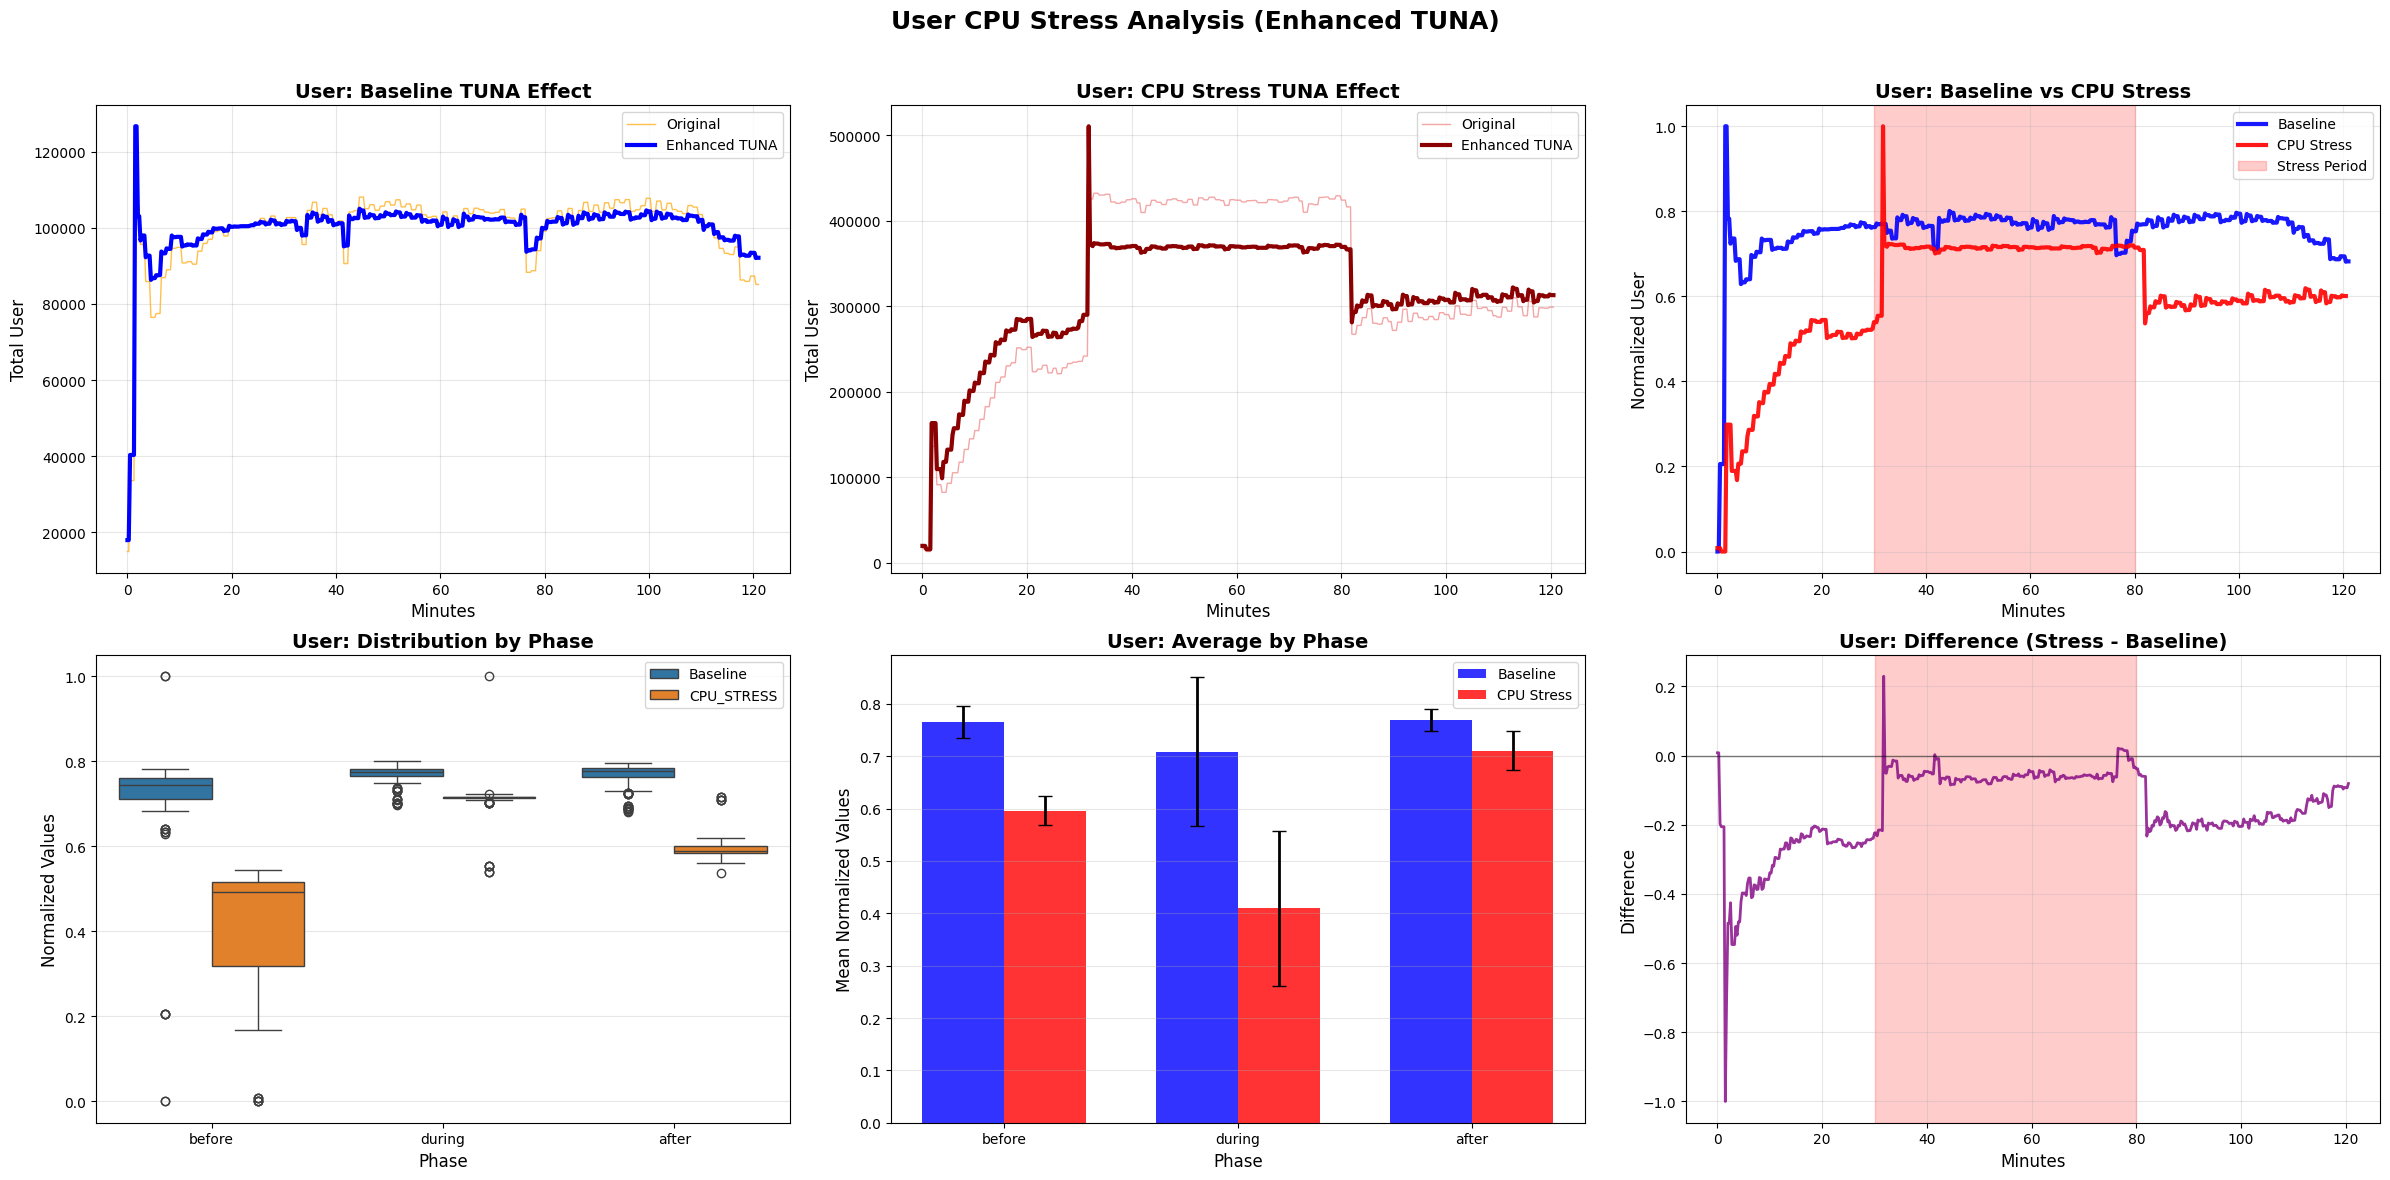

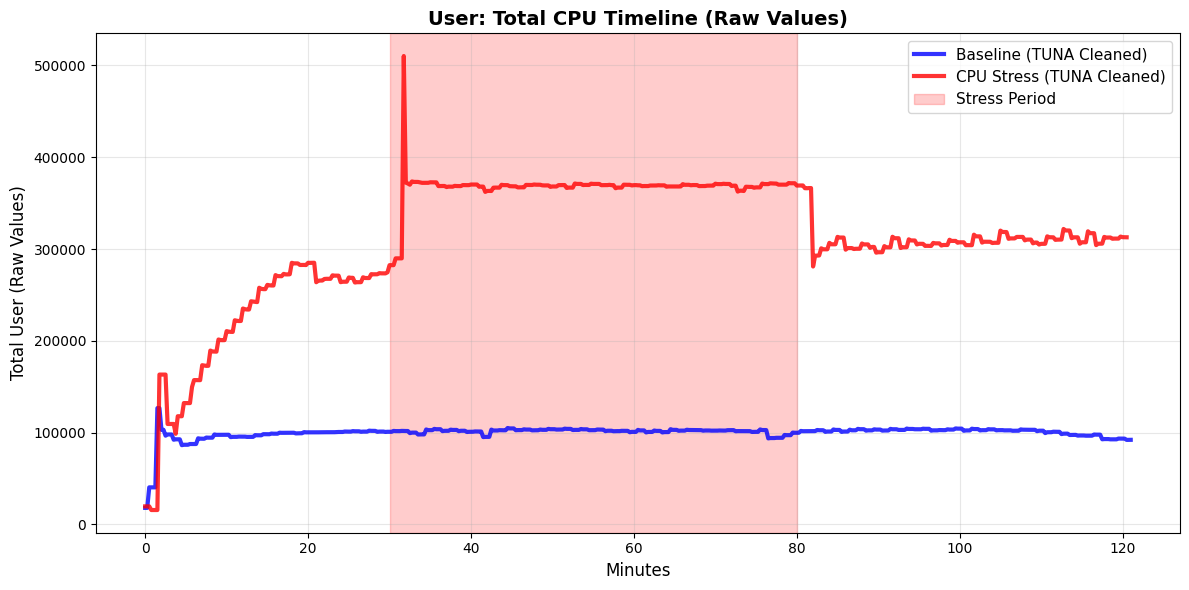


USER - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7650  0.0302  0.6816  0.7968
before  0.7087  0.1422  0.0000  1.0000
during  0.7696  0.0208  0.6968  0.8008

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5956  0.0276  0.5364  0.7149
before  0.4093  0.1473  0.0000  0.5447
during  0.7105  0.0371  0.5394  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 16.02, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 19.70, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 52.87, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -42.24% (↘️ DECREASE)
  DURING  :   -7.68% (↘️ DECREASE)
  AFTER   :  -22.14% (↘️ DECREASE)

🔄 Analyzing Utilization...

📊 Plotting Enhanced TUNA cleaned data for Utilization...


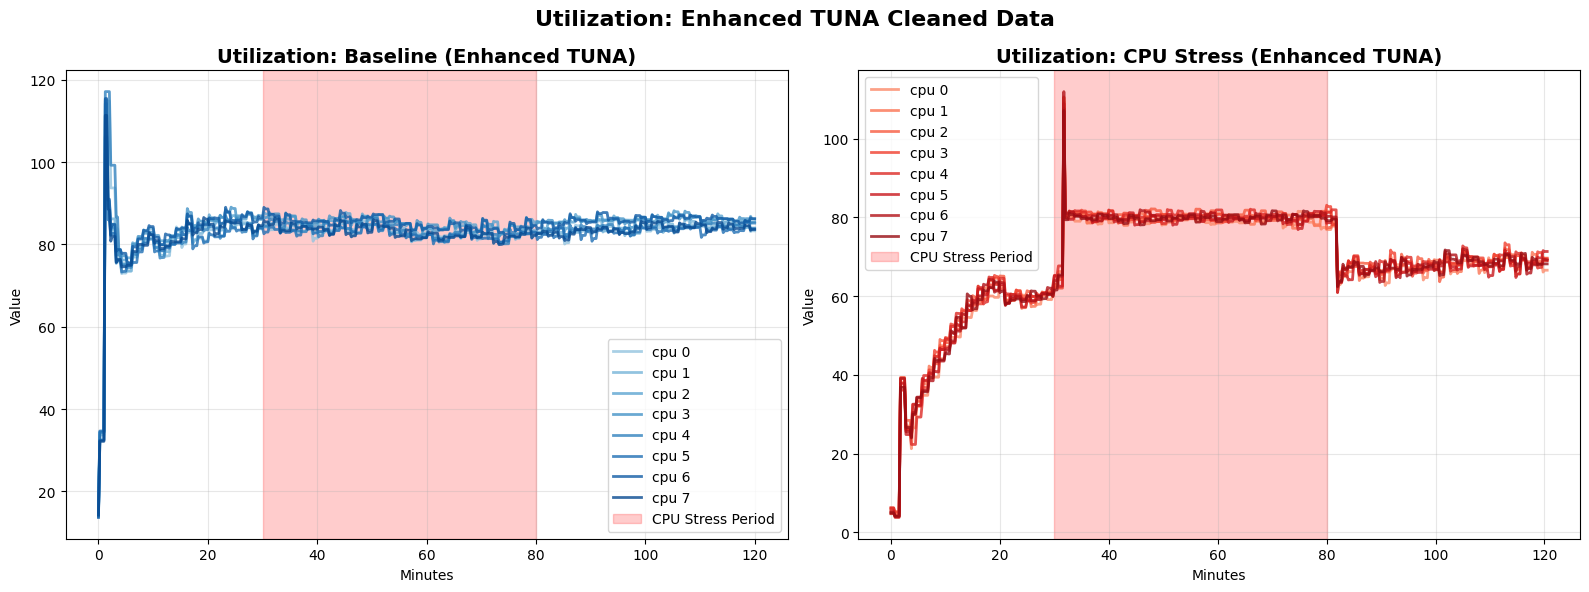

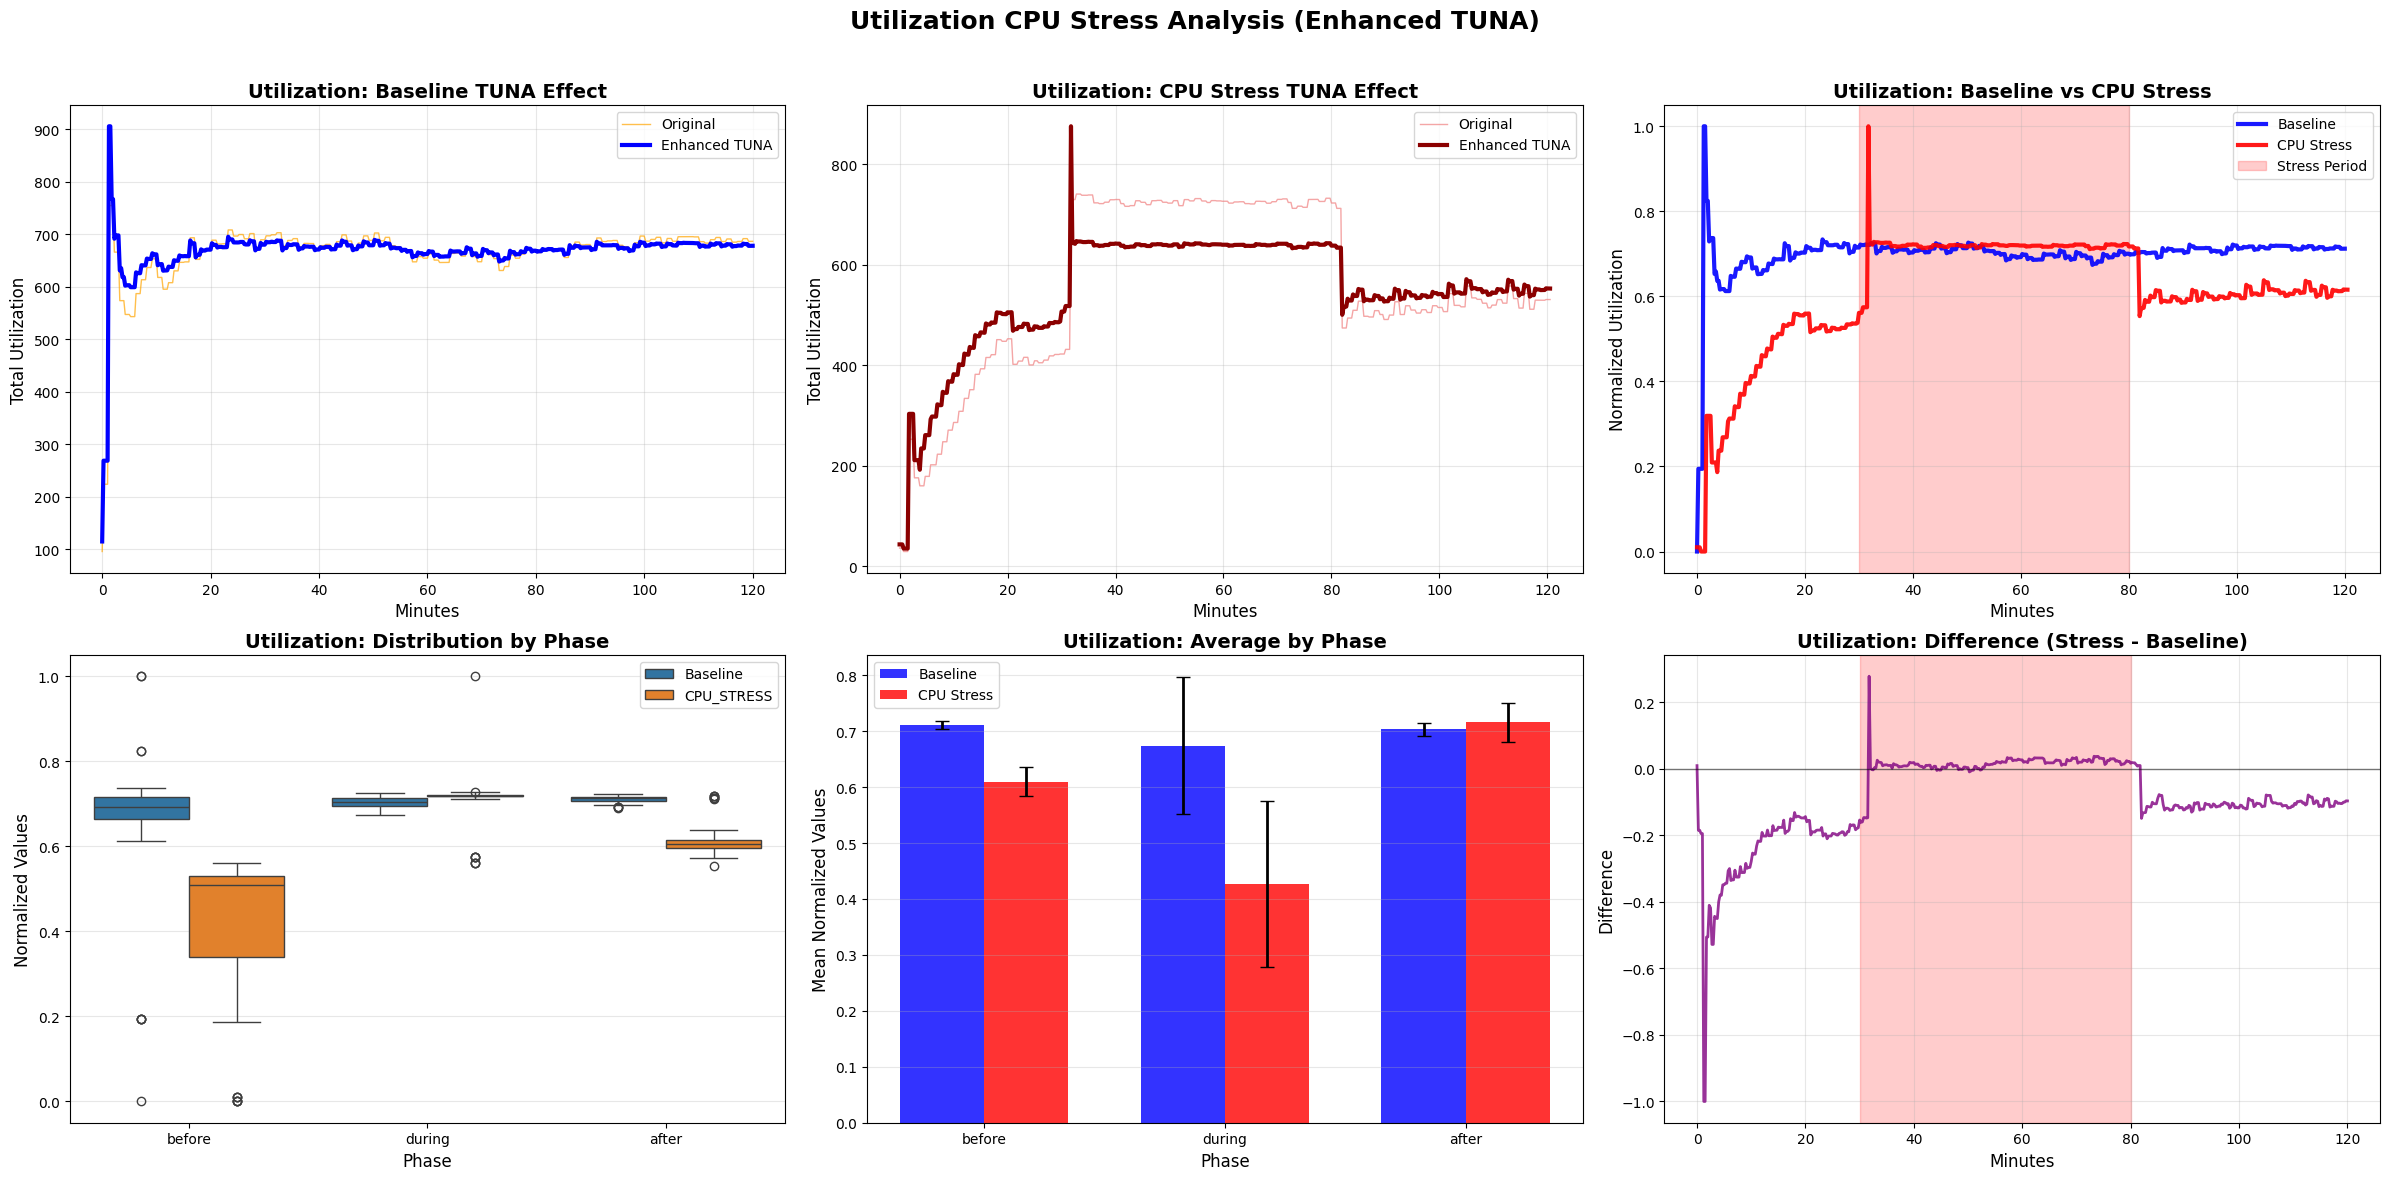

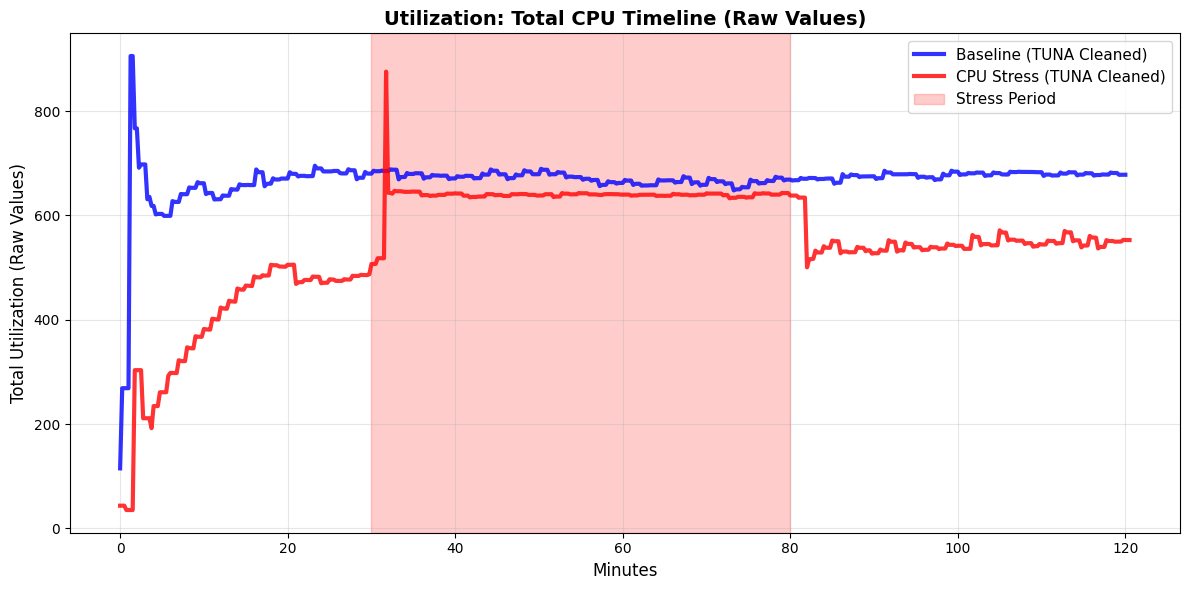


UTILIZATION - ENHANCED TUNA ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7110  0.0065  0.6904  0.7219
before  0.6743  0.1221  0.0000  1.0000
during  0.7034  0.0117  0.6741  0.7265

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6092  0.0260  0.5536  0.7173
before  0.4268  0.1475  0.0000  0.5597
during  0.7156  0.0344  0.5612  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 14.16, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -4.75, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 47.87, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -36.71% (↘️ DECREASE)
  DURING  :   +1.73% (↗️ INCREASE)
  AFTER   :  -14.32% (↘️ DECREASE)


In [6]:
# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result


# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df


# PLOT INDIVIDUAL CPU COLUMNS (UPDATED)
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # CPU Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress (Enhanced TUNA)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: Enhanced TUNA Cleaned Data', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# MAIN ANALYSIS FUNCTION 
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Use the corrected cpu column filter
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]
    
    print(f"\n📊 Plotting Enhanced TUNA cleaned data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Use TUNA-cleaned Total_CPU_TUNA if available
    if 'Total_CPU_TUNA' in cpu_stress_df.columns:
        cpu_stress_df['Total'] = cpu_stress_df['Total_CPU_TUNA']
        baseline_df['Total'] = baseline_df['Total_CPU_TUNA']
    else:
        cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
        baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals (with safe division)
    cpu_stress_range = cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min()
    baseline_range = baseline_df['Total'].max() - baseline_df['Total'].min()
    
    if cpu_stress_range > 0:
        cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / cpu_stress_range
    else:
        cpu_stress_norm['Total'] = 0
        
    if baseline_range > 0:
        baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / baseline_range
    else:
        baseline_norm['Total'] = 0
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPARISON PLOTS
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline TUNA effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Original', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS TUNA effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='Original', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='Enhanced TUNA', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress TUNA Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Difference (Stress - Baseline)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Stress Analysis (Enhanced TUNA)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

    plot_cumulative_cpu_raw(dataset_name, cpu_stress_clean, baseline_clean, delay, duration)
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - ENHANCED TUNA ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

def plot_cumulative_cpu_raw(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot only cumulative CPU timeline (raw values, not normalized)
    """
    
    # Get total CPU values
    stress_total = cpu_stress_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in cpu_stress_df.columns else cpu_stress_df[[col for col in cpu_stress_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    baseline_total = baseline_df['Total_CPU_TUNA'] if 'Total_CPU_TUNA' in baseline_df.columns else baseline_df[[col for col in baseline_df.columns if col.startswith('cpu') and col not in ['cpu 8', 'cpu 9'] and '_' not in col]].sum(axis=1)
    
    # Single plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(baseline_df['Minutes'], baseline_total, 
             label='Baseline (TUNA Cleaned)', linewidth=3, color='blue', alpha=0.8)
    plt.plot(cpu_stress_df['Minutes'], stress_total, 
             label='CPU Stress (TUNA Cleaned)', linewidth=3, color='red', alpha=0.8)
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress Period")
    
    plt.title(f'{dataset_name}: Total CPU Timeline (Raw Values)', fontweight='bold', fontsize=14)
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name} (Raw Values)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print simple summary
    baseline_mean = baseline_total.mean()
    stress_mean = stress_total.mean()
    difference = stress_mean - baseline_mean
    percent_change = (difference / baseline_mean) * 100 if baseline_mean != 0 else 0


# RUN ANALYSIS (FIXED)
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU STRESS ANALYSIS - ENHANCED TUNA")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )